In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [134]:
data = pd.read_csv('dataset.csv')
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 32 columns):
ApplStandard                397 non-null object
Brand                       397 non-null object
Cap                         397 non-null float64
Combination                 397 non-null bool
Control                     397 non-null object
Country                     397 non-null object
Depth                       223 non-null float64
Height                      223 non-null float64
Model No                    397 non-null object
Family Name                 106 non-null object
N-Standard                  397 non-null object
New CEC                     397 non-null int64
New SRI                     397 non-null float64
New Star                    397 non-null float64
Prog Name                   397 non-null object
Prog Time                   397 non-null float64
Sold_in                     387 non-null object
SubmitStatus                397 non-null object
Submit_ID                   

In [135]:
# Let us first find see the features which we might have to drop
print(data.columns.values)

# As we can see here, Grand Date and Old Star Rating are entirely empty so we can drop them
print(data.isnull().sum(), '\n')

# For each of these features, more than 97% of the values are the same, we can drop these as well
print(pd.value_counts(data['N-Standard']), '\n')
print(pd.value_counts(data['SubmitStatus']), '\n')
print(pd.value_counts(data['Product Class']), '\n')
print(pd.value_counts(data['Availability Status']), '\n')
columns = ['Model No', 'Family Name', 'Sold_in', 'N-Standard', 'SubmitStatus', 'Submit_ID', 'GrandDate', 'Product Class', 'Product Website', 'Old Star Rating', 'Star Image Large', 'Star Image Small', 'Availability Status', 'Representative Brand URL']

# Dropping the columns
data.drop(columns, axis=1, inplace=True)
print(data.head(4), '\n')
print(data.info())

['ApplStandard' 'Brand' 'Cap' 'Combination' 'Control' 'Country' 'Depth'
 'Height' 'Model No' 'Family Name' 'N-Standard' 'New CEC' 'New SRI'
 'New Star' 'Prog Name' 'Prog Time' 'Sold_in' 'SubmitStatus' 'Submit_ID'
 'Test_Moist_Remove' 'Tot_Wat_Cons' 'Type' 'Width' 'ExpDate' 'GrandDate'
 'Product Class' 'Availability Status' 'Product Website'
 'Representative Brand URL' 'Old Star Rating' 'Star Image Large'
 'Star Image Small']
ApplStandard                  0
Brand                         0
Cap                           0
Combination                   0
Control                       0
Country                       0
Depth                       174
Height                      174
Model No                      0
Family Name                 291
N-Standard                    0
New CEC                       0
New SRI                       0
New Star                      0
Prog Name                     0
Prog Time                     0
Sold_in                      10
SubmitStatus               

In [136]:
# Fill up missing value columns
missing_values_columns = [column for column in data.columns.values if data[column].isnull().sum()>0]
print(missing_values_columns)

# Firstly we shall combine Brand and Country into a single column
Brand_Country = []
for index, row in data.iterrows():
    if len(row['Country'])>1: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1] + row['Country'][1][:1]).upper())
    else: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1]).upper())
data['Brand_Country'] = Brand_Country
    
# To fill missing values in Depth
mode_depth_overall = data['Depth'].value_counts().index[0]
data['Depth'] = data['Depth'].fillna(0)
for index, row in data.iterrows():
    if int(row['Depth']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Depth'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Depth'].mode().values[0])
        if brand_country_mode!=0:
            data.at[index, 'Depth'] = brand_country_mode
        elif country_mode!=0:
            data.at[index, 'Depth'] = country_mode
        else: 
            data.at[index, 'Depth'] = mode_depth_overall
    else: 
        data.at[index, 'Depth'] = int(data.at[index, 'Depth'])
data['Depth'] = data['Depth'].astype(int)

# To fill missing values in Height
mode_height_overall = data['Height'].value_counts().index[0]
data['Height'] = data['Height'].fillna(0)
for index, row in data.iterrows():
    if int(row['Height']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Height'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Height'].mode().values[0])
        if brand_country_mode!=0:
            data.at[index, 'Height'] = brand_country_mode
        elif country_mode!=0:
            data.at[index, 'Height'] = country_mode
        else: 
            data.at[index, 'Height'] = mode_depth_overall
    else: 
        data.at[index, 'Height'] = int(data.at[index, 'Height'])
data['Height'] = data['Height'].astype(int)

# For total water consumption, since the mode value is 0, we will fill the empty values with 0
data['Tot_Wat_Cons'] = data['Tot_Wat_Cons'].fillna(0)
data['Tot_Wat_Cons'] = data['Tot_Wat_Cons'].astype(int)

# To fill missing values in Width
mode_height_overall = data['Width'].value_counts().index[0]
data['Width'] = data['Width'].fillna(0)
for index, row in data.iterrows():
    if int(row['Width']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Width'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Width'].mode().values[0])
        if brand_country_mode!=0:
            data.at[index, 'Width'] = brand_country_mode
        elif country_mode!=0:
            data.at[index, 'Width'] = country_mode
        else: 
            data.at[index, 'Width'] = mode_depth_overall
    else: 
        data.at[index, 'Width'] = int(data.at[index, 'Width'])
data['Width'] = data['Width'].astype(int)

# Filling up missing ExpDate values
mode_year = int(data.ExpDate.value_counts().index[0].split('/')[2])
data.ExpDate = data.ExpDate.fillna('0')
for index, row in data.iterrows():
    if data.at[index, 'ExpDate']:
        if len(data.at[index, 'ExpDate'].split('/'))==3:
            data.at[index, 'ExpDate'] = data.at[index, 'ExpDate'].split('/')[2]
        else:
            data.at[index, 'ExpDate'] = mode_year

data['ExpDate'] = data['ExpDate'].astype(int)

for index, rows in data.iterrows():
    capacity = int(data.at[index, 'Cap'])
    if capacity>=60 and capacity<=490: value = 0
    elif capacity>=3 and capacity<=4: value = 1
    elif capacity>=5 and capacity<=6: value = 2
    elif capacity>=7 and capacity<=8: value = 3
    else: value = 4
    data.at[index, 'Cap'] = value    
data['Cap'] = data['Cap'].astype(int)

for index, rows in data.iterrows():
    depth = int(data.at[index, 'Depth'])
    if depth>=60 and depth<=550: value = 0
    elif depth==555: value = 1
    elif depth>=560 and depth<=700: value = 2
    else: value = 3
    data.at[index, 'Depth'] = value    
data['Depth'] = data['Depth'].astype(int)


data['New SRI'] = data['New SRI'].astype(int)
data['New Star'] = data['New Star'].astype(int)
data['Prog Time'] = data['Prog Time'].astype(int)
data['Test_Moist_Remove'] = data['Test_Moist_Remove'].astype(int)

data['Depth'].value_counts()

['Depth', 'Height', 'Tot_Wat_Cons', 'Width', 'ExpDate']


1    174
2    143
0     69
3     11
Name: Depth, dtype: int64

In [137]:
# We shall extract the features fro the Program Name and seperate them into different classes
def return_features(data, i):
    program = data.at[i, 'Prog Name']
    if '/' in program:
        types = program.split('/')
        program = ''
        for t in types:
            program+=t+' '
    if ',' in program:
        types = program.split(',')
        program = ''
        for t in types:
            program+=t+' '
    keywords = program.split(' ')
    features = []
    for i in keywords: 
        i = i.strip()
        if i not in ['', '-']: features.append(i.lower())
    return features
    
#     print(data.at[i, 'Prog Name'])
for i, row in data.iterrows():
    features = return_features(data, i)
    if 'dry' in features and 'heat' in features: data.at[i, 'Prog Name'] = 0
    elif 'heat' in features: data.at[i,'Prog Name'] = 1
    elif 'dry' in features: data.at[i, 'Prog Name'] = 2
    else: data.at[i, 'Prog Name'] = 3

data['Prog Name'] = data['Prog Name'].astype(int)

# As we can see we have removed all the null values are removed, now we must convert all the other data type
# to int type, by mapping boolean and objects to int
ApplStandard_types = {'AS/NZS 2442.2:2000/Amdt 2:2007 (Legacy)': 0, 'Greenhouse and Energy Minimum Standards (Rotary Clothes Dryers) Determination 2012': 1, 'Greenhouse and Energy Minimum Standards (Rotary Clothes Dryers) Determination 2015': 2, 'AS/NZS 2442.2:2000/Amdt 2:2007': 3}
data['ApplStandard'] = data['ApplStandard'].map(ApplStandard_types).astype(int)
data['Combination'] = data['Combination'].map({False: 0, True: 1}).astype(int)
data['Control'] = data['Control'].map({'Timer': 0, 'Autosensing': 1, 'Manual': 2}).astype(int)
data['Type'] = data['Type'].map({'Condenser': 0, 'Vented': 1}).astype(int)
# data.info()

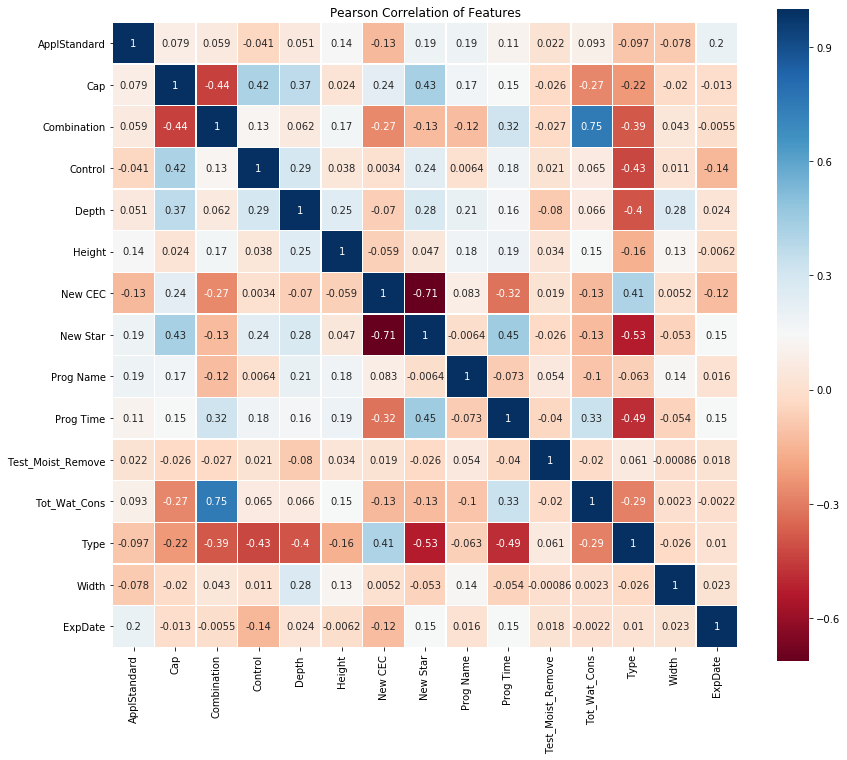

In [138]:
# We have converted all the initial types into integer type
# For now we shall not consider the effects of Brand_country, Brand and Country
data.drop(['Brand_Country', 'Brand', 'Country', 'New SRI'], axis=1, inplace=True)
# print(data.info())

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

# data[['Combination', 'Tot_Wat_Cons']]

In [139]:
# train_x = data.drop('New Star', axis=1)
# train_y = data['New Star']
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)

# train_x

In [140]:
# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(train_x, train_y)

# random_forest_predictions = random_forest.predict(train_x)

# random_forest_accuracy = round(random_forest.score(train_x, train_y) * 100, 2)
# print("Accuracy: " ,random_forest_accuracy)

# print("Precision score: ", precision_score(train_y, random_forest_predictions, average=None))
# print("Recall score: ", recall_score(train_y, random_forest_predictions, average=None))
# print("F Score: ", f1_score(train_y, random_forest_predictions, average=None))

In [141]:
# random_forest_val = RandomForestClassifier(n_estimators=100)
# random_forest_val.fit(test_x, test_y)

# random_forest_predictions_val = random_forest_val.predict(test_x)

# random_forest_accuracy_val = round(random_forest_val.score(test_x, test_y) * 100, 2)
# print("Accuracy: " ,random_forest_accuracy_val)

# print("Precision score: ", precision_score(test_y, random_forest_predictions_val, average='weighted'))
# print("Recall score: ", recall_score(test_y, random_forest_predictions_val, average='weighted'))
# print("F Score: ", f1_score(test_y, random_forest_predictions_val, average='weighted'))